Classification and Regression are the most common types of ML problems.

### 0. General Architecture of a Classification Neural Network

This components list will vary depending on the considered problem.

### 1. Make classification data and get it ready

In [1]:
# Making some data
from sklearn.datasets import make_circles

# 1000 samples
n_samples = 1000

# Create circles(data)
X, y = make_circles(n_samples, noise = 0.03, random_state = 69)

In [2]:
# Just a view of the created data samples; first 5
X[:5], y[:5]

(array([[-0.51839217, -0.66522091],
        [ 0.78398275, -0.00098577],
        [ 0.12616247, -0.75963138],
        [-0.70384469, -0.32717022],
        [ 0.67524498, -0.34785267]]),
 array([1, 1, 1, 1, 1]))

In [3]:
# Make DataFrame of (generated) circle data
import pandas as pd
circles = pd.DataFrame({"X1" : X[:, 0], "X2" : X[:, 1], "label" : y})
circles.head(10)

,X1,X2,label
0,-0.518392,-0.665221,1
1,0.783983,-0.000986,1
2,0.126162,-0.759631,1
3,-0.703845,-0.327170,1
4,0.675245,-0.347853,1
5,-0.750599,-0.141688,1
6,0.721272,-0.431657,1
7,-0.625116,0.572249,1
8,0.983314,0.248923,0
9,0.251079,0.962878,0


The label y has two values, either 0 or 1, hence, the problem is a **Binary Classification**.

In [4]:
# Check the different (unique) labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

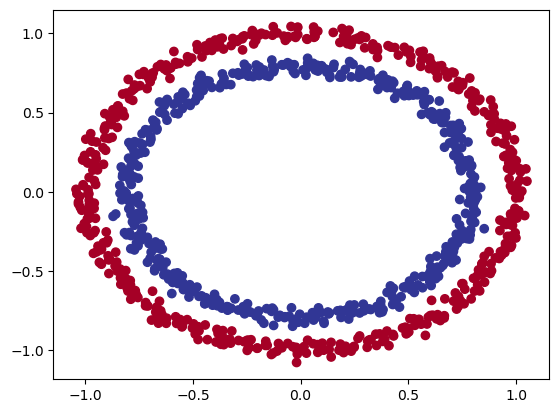

In [5]:
# Data Visualization
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

Now, we have a problem to solve. To classify dots into red (0) or blue (1).

#### 1.1 Input and Output shapes

Most common error in DL is shape mismatch errors.

wHat shapes are my inputs and what shapes are my outputs ? Familiarize oneself with the shapes of data to avoid those errors.

In [6]:
# Shape check of features and labels
X.shape, y.shape

((1000, 2), (1000,))

Often helpful to view a single sample's values and shapes to understand the input and output (features & labels) shapes.

#### 1.2 Turning data into tensors and create train & test splits

In [7]:
# Conversion of the data (numpy arrays) into tensors; PyTorch prefers tensors to work with and that too in float datatype
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Take a view of some samples
X[:5], y[:5]

(tensor([[-0.5184, -0.6652],
         [ 0.7840, -0.0010],
         [ 0.1262, -0.7596],
         [-0.7038, -0.3272],
         [ 0.6752, -0.3479]]),
 tensor([1., 1., 1., 1., 1.]))

In [8]:
# Data Splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 69)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### 2. Building a Model

In [9]:
from torch import nn

# Device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Given X (features) we want our model to predict y (label).

This features and labels setup is referred to as Supervised Learning.

To create such a model, it will need to handle the i/p and o/p shapes of X and y.

In [10]:
# 1. Model class construction subclassing nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Creating 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features = 2, out_features = 5) # Take 2 (X) features; produces 5
        self.layer_2 = nn.Linear(in_features = 5, out_features = 1) # Taks 5 features; produces 1 feature (y)

    # 3. Define the forward (method) pass (frwd computation)
    def forward(self, x):
        # Return the output of layer_2 (a single feature, the same shape as y)
        return self.layer_2(self.layer_1(x))

# 4. Model instance creation and sending to the device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

The number of hidden units one can use in NN layers is a **hyperparameter.**

**nn.Sequential** performs the similar task of forward computation of the input data through the layers in the order they appear.

In [11]:
# Replication of CirCircleModelV0 with nn.Sequnetial
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
# Predictions with the model
untrained_preds = model_0(X_test.to(device))
print(len(untrained_preds), untrained_preds.shape)
print(len(y_test), y_test.shape)
# View the first few predictions
print(untrained_preds[:10])
print(y_test[:10])

200 torch.Size([200, 1])
200 torch.Size([200])
tensor([[ 0.4126],
        [ 0.3236],
        [ 0.1038],
        [ 0.1976],
        [ 0.2365],
        [ 0.2008],
        [ 0.0858],
        [-0.2211],
        [ 0.3470],
        [-0.2385]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([0., 0., 0., 0., 0., 1., 1., 0., 1., 0.])


Now, here is a shape mismatch between the predcitions and the labels, mainly for shape. These cn be resolved later on.

#### 2.1 Setup loss function and optimizer

In [13]:
# Loss function creation
loss_fn = nn.BCEWithLogitsLoss() # this has sigmoid layer built-in; more numerically stable than nn.BCELoss() acc. to PyTorch docs.

# Optimizer creation
optimizer = torch.optim.SGD(params=model_0.parameters(), lr = 0.1)

Creating an **evaluation metric**; it gives a **different perspective** to the model's performance. Several of them are available.

It can be thought of as how right the model is if the loss is thought of as how bad the model performs.

In [14]:
# Accuracy Calculation (A classification evaluation metric)

def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq compares two tensors for wherever they are equal.
    acc = (correct / len(y_pred)) * 100
    return acc

### 3. Train Model

#### From raw model o/ps to predicted labels (logits -> prediciton probabilities -> prediction labels)

In [15]:
# To understand what the model outputs at the very initial stage, view some outputs on test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.4126],
        [0.3236],
        [0.1038],
        [0.1976],
        [0.2365]], device='cuda:0', grad_fn=<SliceBackward0>)

These raw outputs out of the untrained model are often referred to as **Logits**.

However, these numbers are hard to interpret. Therefore, need numbers that are comparable to the truth labels.

To do so, **Sigmoid activation function** comes into the picture; from logits to comparable numbers to truth labels.

In [16]:
# Signmoid fn on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6017],
        [0.5802],
        [0.5259],
        [0.5492],
        [0.5588]], device='cuda:0', grad_fn=<SigmoidBackward0>)

Since dealing with binary classification, these values can be viewed as a **decision boundary**.

In [17]:
# To turn the prediciton probs into prediciton labels, round the o/ps of the Sigmoid activation function

# Find predicited labels (round the probs)
y_preds = torch.round(y_pred_probs)

# Or, in full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Ewuality check
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds, y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


(tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]], device='cuda:0', grad_fn=<RoundBackward0>),
 tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>))

In [18]:
y_test[:5]

tensor([0., 0., 0., 0., 0.])

#### 3.2 Building a training and testing loop

In [19]:
torch.manual_seed(69)

# Number of epochs
epochs = 100

# Loading data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training & testing loop
for epoch in range(epochs):
    # Training
    model_0.train()

    # 1. Forward Pass (logits as o/p)
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

    # 2. Calculate loss/acc
    loss = loss_fn(y_logits, y_train) # because nn.BCEWithLogitsLoss is used as the loss fn; sigmoid built-in
    acc = accuracy(y_true = y_train, y_pred = y_pred)

    # 3. Zero grad
    optimizer.zero_grad()

    # 4. Backprop
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Testing
    model_0.eval()

    with torch.inference_mode():
         # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(y_true = y_test, y_pred = test_pred)

    # Print the stats every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f}, Train Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.69879, Train Accuracy: 51.62% | Test Loss: 0.70316, Test Accuracy: 48.50%
Epoch: 10 | Train Loss: 0.69743, Train Accuracy: 51.50% | Test Loss: 0.70293, Test Accuracy: 48.50%
Epoch: 20 | Train Loss: 0.69647, Train Accuracy: 51.38% | Test Loss: 0.70251, Test Accuracy: 47.50%
Epoch: 30 | Train Loss: 0.69575, Train Accuracy: 50.88% | Test Loss: 0.70201, Test Accuracy: 48.50%
Epoch: 40 | Train Loss: 0.69518, Train Accuracy: 50.88% | Test Loss: 0.70151, Test Accuracy: 47.50%
Epoch: 50 | Train Loss: 0.69472, Train Accuracy: 50.88% | Test Loss: 0.70103, Test Accuracy: 47.50%
Epoch: 60 | Train Loss: 0.69435, Train Accuracy: 51.00% | Test Loss: 0.70060, Test Accuracy: 48.00%
Epoch: 70 | Train Loss: 0.69405, Train Accuracy: 51.00% | Test Loss: 0.70022, Test Accuracy: 47.00%
Epoch: 80 | Train Loss: 0.69381, Train Accuracy: 50.75% | Test Loss: 0.69989, Test Accuracy: 47.50%
Epoch: 90 | Train Loss: 0.69361, Train Accuracy: 50.50% | Test Loss: 0.69960, Test Accuracy: 48.50%


### 4. Making preds and evaluating the model

In [20]:
import requests
from pathlib import Path

# Downloading helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


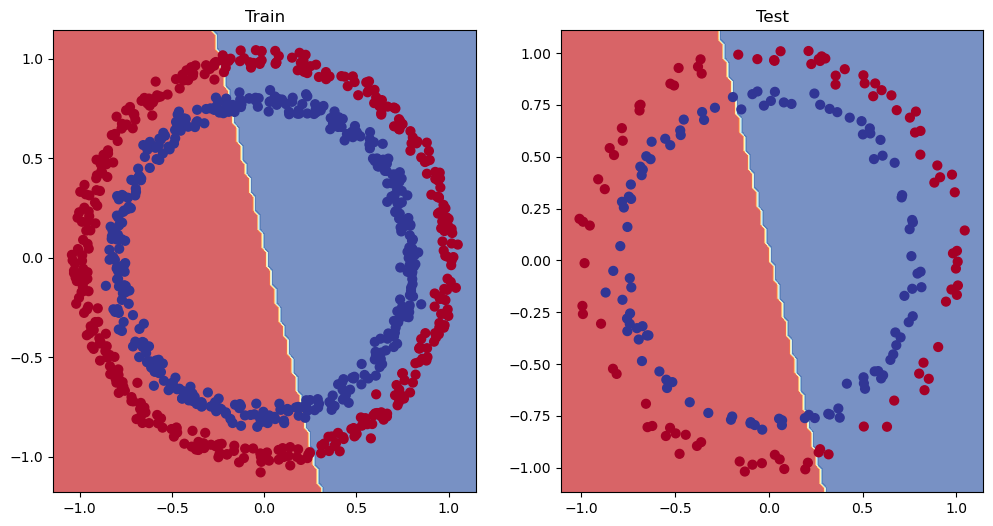

In [21]:
# Plot decision boundaries for train and test sets
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### 5. Improving a model (from a model perspective)

In [22]:
# Model modified with an extra layer, fit for longer and increase the number of hidden units to see what happens ?
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 10) # More number of hidden units from 5 to 10
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10) # Extra layer
        self.layer_3 = nn.Linear(in_features = 10, out_features = 1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

# Put model to the target device
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [23]:
loss_fn = nn.BCEWithLogitsLoss() # no requirement of sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr = 0.1)

In [24]:
torch.manual_seed(69)

# Number of epochs; This time fitting for longer from 100 to 1000 epochs
epochs = 1000

# Putting data onto the same target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Training
    # model_1.train()

    # Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

    # Calculate loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_true = y_train, y_pred = y_pred)

    # Optimzer zero grad
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Step the optimizer
    optimizer.step()

    # Testing
    model_1.eval()

    with torch.inference_mode():
        # Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(y_true = y_test, y_pred = test_pred)

    # Print the train and eval stats every 100th epoch
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f}, Train Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.69591, Train Accuracy: 50.62% | Test Loss: 0.68945, Test Accuracy: 56.00%
Epoch: 100 | Train Loss: 0.69304, Train Accuracy: 50.75% | Test Loss: 0.69438, Test Accuracy: 47.00%
Epoch: 200 | Train Loss: 0.69279, Train Accuracy: 42.62% | Test Loss: 0.69571, Test Accuracy: 36.00%
Epoch: 300 | Train Loss: 0.69273, Train Accuracy: 48.88% | Test Loss: 0.69642, Test Accuracy: 40.50%
Epoch: 400 | Train Loss: 0.69271, Train Accuracy: 50.25% | Test Loss: 0.69679, Test Accuracy: 40.50%
Epoch: 500 | Train Loss: 0.69271, Train Accuracy: 50.38% | Test Loss: 0.69698, Test Accuracy: 41.00%
Epoch: 600 | Train Loss: 0.69271, Train Accuracy: 50.12% | Test Loss: 0.69708, Test Accuracy: 41.00%
Epoch: 700 | Train Loss: 0.69271, Train Accuracy: 50.12% | Test Loss: 0.69713, Test Accuracy: 41.00%
Epoch: 800 | Train Loss: 0.69271, Train Accuracy: 50.00% | Test Loss: 0.69715, Test Accuracy: 41.00%
Epoch: 900 | Train Loss: 0.69271, Train Accuracy: 50.00% | Test Loss: 0.69716, Test Accuracy:

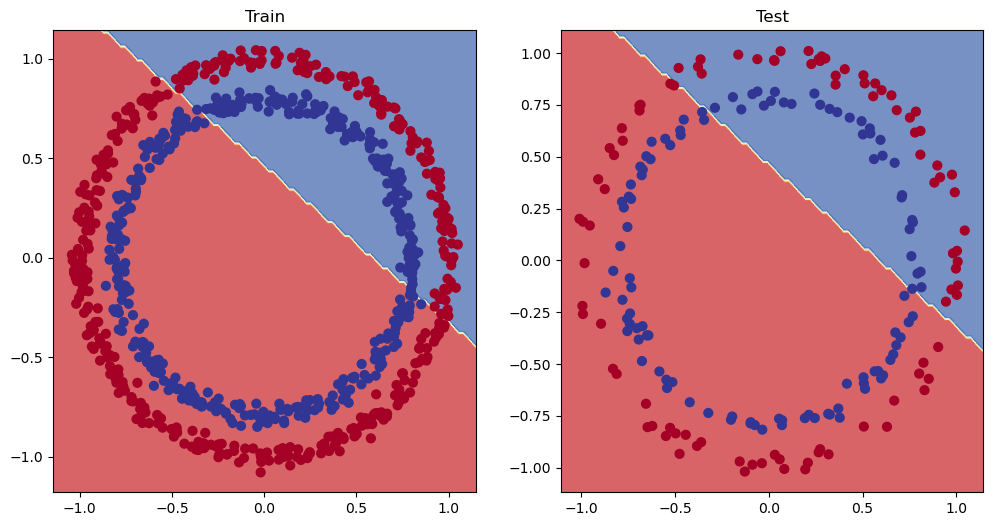

In [25]:
# Visualize the results of the modified model and its training by plotting decision boundaries for train and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

#### 5.1 Preparing data to see if the model can model a straight line

Doing this to see if the model is able to model the linear data & is not just a model which cannot learn anything.

In [26]:
# Some data creation
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression

# Data checks
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [27]:
# Data Splitting
split_ratio = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:split_ratio], y_regression[:split_ratio]
X_test_regression, y_test_regression = X_regression[split_ratio:], y_regression[split_ratio:]

len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

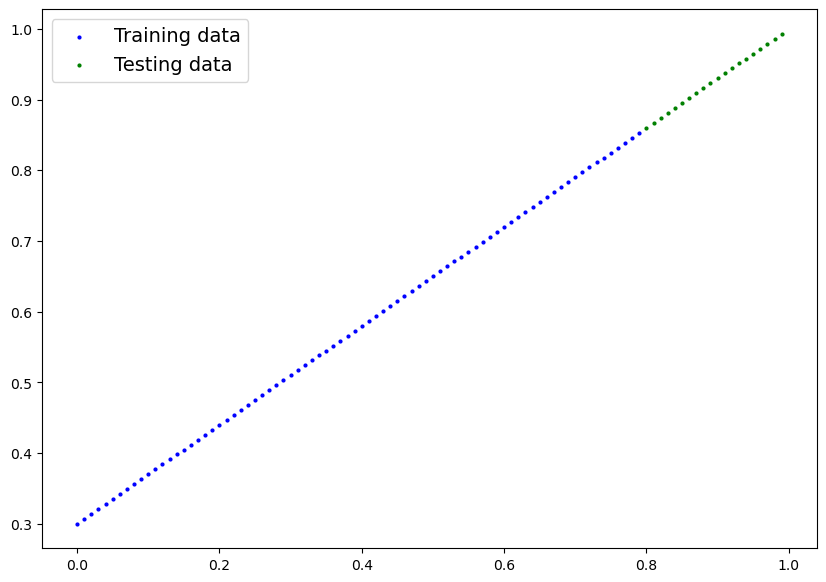

In [28]:
# Data Visualization
plot_predictions(X_train_regression, y_train_regression, X_test_regression, y_test_regression)

#### 5.2 Adjusting model_1 to fit a straight line

In [29]:
# Same architecture as model_1 but using nn.Sequential
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

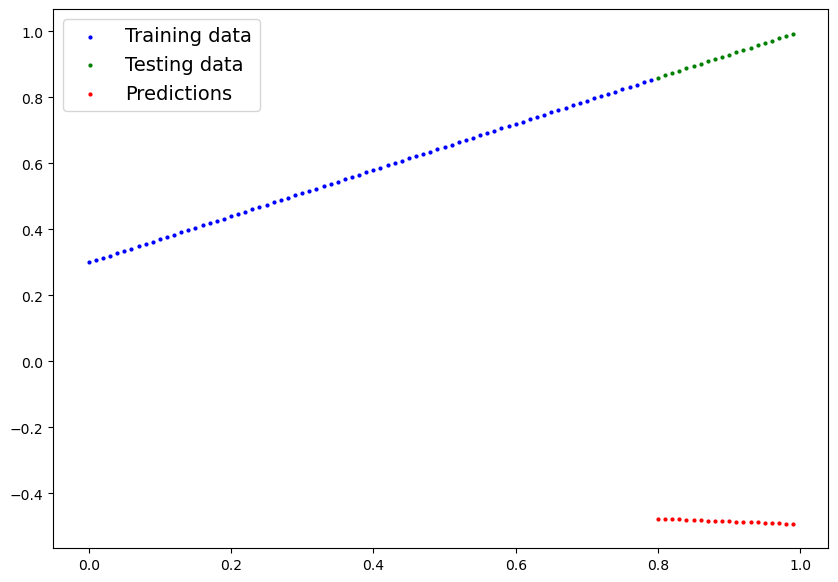

In [30]:
# Just for better understanding of mine
model_2.eval()
with torch.inference_mode():
    y_preds = model_2(X_test_regression.to(device))

plot_predictions(X_train_regression, y_train_regression, X_test_regression.cpu(), y_test_regression, y_preds.cpu())

In [31]:
#Loss function setup
loss_fn = nn.L1Loss()

# Optimizer setup
optimizer = torch.optim.SGD(params=model_2.parameters(), lr = 0.1)

In [32]:
# Training and testing the model
torch.manual_seed(69)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    # Training
    model_2.train()
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    if epoch % 100 == 0:
         print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 1.01970, Test loss: 0.82519
Epoch: 100 | Train loss: 0.06358, Test loss: 0.21205
Epoch: 200 | Train loss: 0.07935, Test loss: 0.17758
Epoch: 300 | Train loss: 0.04924, Test loss: 0.16646
Epoch: 400 | Train loss: 0.05724, Test loss: 0.15268
Epoch: 500 | Train loss: 0.08374, Test loss: 0.12828
Epoch: 600 | Train loss: 0.07433, Test loss: 0.13728
Epoch: 700 | Train loss: 0.05192, Test loss: 0.14310
Epoch: 800 | Train loss: 0.06578, Test loss: 0.12066
Epoch: 900 | Train loss: 0.06096, Test loss: 0.08705


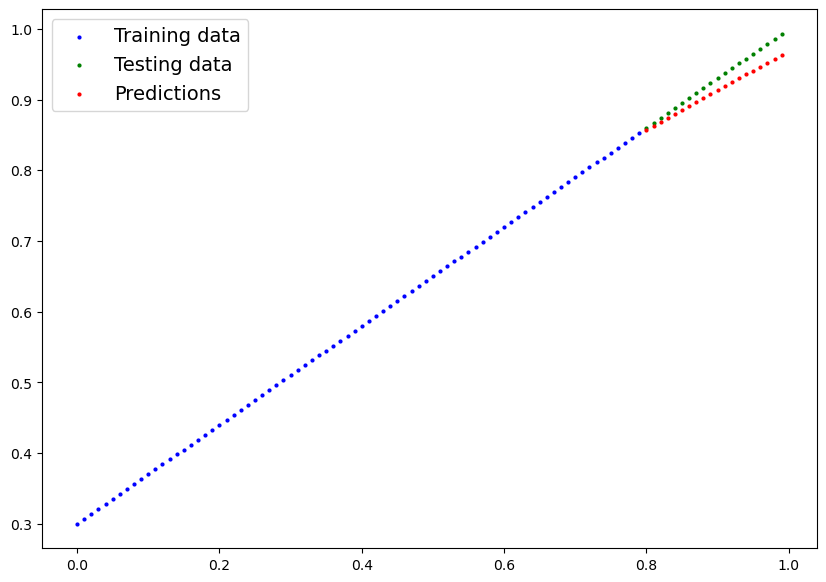

In [33]:
# Model data & predictions visualization
model_2.eval()

# Inference
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plotting data and predictions with on the CPU (because plt can't work with GPU loaded data)
plot_predictions(X_train_regression.cpu(), y_train_regression.cpu(), X_test_regression.cpu(), y_test_regression.cpu(), y_preds.cpu())

### 6. The missing piece: Non-Linearity

#### 6.1 Recreating non-linear data (Circles data)

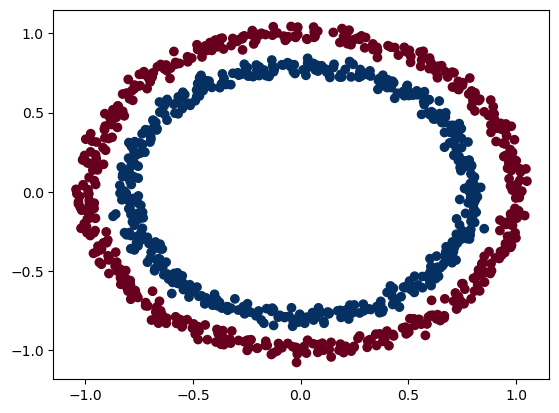

In [34]:
# Create and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples = 1000, noise = 0.03, random_state = 69)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap = plt.cm.RdBu)

In [35]:
# Data Splitting
import torch
from sklearn.model_selection import train_test_split

# Convert to tensors for PyTorch to work with them
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 69)

X_train[:5], y_train[:5]

(tensor([[ 0.8034, -0.1072],
         [-0.2292,  0.9914],
         [-0.5869, -0.5160],
         [ 0.9750, -0.2808],
         [ 0.9769, -0.1566]]),
 tensor([1., 0., 1., 0., 0.]))

#### 6.2 Building a model with non-linearity

In [36]:
# Build model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # ReLU non-linear activation function added
        # sigmoid can also be used which would mean not to use it on predictions (self.sigmoid = nn.Sigmoid())

    def forward(self, x):
        # Intersperse the ReLU activation between the layers
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [37]:
# loss and optimizer creation
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr = 0.1)

#### 6.3 Training the model with non-linearity

In [38]:
# Model Fitting
torch.manual_seed(69)

epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Training
    model_3.train()
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_true = y_train, y_pred = y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(y_true = y_test, y_pred = test_pred)

    # Print out the stats over training and testing
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f}, Train Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.70067, Train Accuracy: 49.25% | Test Loss: 0.69134, Test Accuracy: 53.00%
Epoch: 100 | Train Loss: 0.68942, Train Accuracy: 52.62% | Test Loss: 0.69274, Test Accuracy: 47.50%
Epoch: 200 | Train Loss: 0.68735, Train Accuracy: 53.87% | Test Loss: 0.69177, Test Accuracy: 48.50%
Epoch: 300 | Train Loss: 0.68434, Train Accuracy: 55.00% | Test Loss: 0.68988, Test Accuracy: 50.50%
Epoch: 400 | Train Loss: 0.67995, Train Accuracy: 57.12% | Test Loss: 0.68703, Test Accuracy: 50.00%
Epoch: 500 | Train Loss: 0.67391, Train Accuracy: 57.12% | Test Loss: 0.68338, Test Accuracy: 49.50%
Epoch: 600 | Train Loss: 0.66495, Train Accuracy: 59.88% | Test Loss: 0.67760, Test Accuracy: 50.00%
Epoch: 700 | Train Loss: 0.65045, Train Accuracy: 65.38% | Test Loss: 0.66719, Test Accuracy: 57.50%
Epoch: 800 | Train Loss: 0.62535, Train Accuracy: 71.88% | Test Loss: 0.64462, Test Accuracy: 64.00%
Epoch: 900 | Train Loss: 0.57859, Train Accuracy: 85.25% | Test Loss: 0.59767, Test Accuracy:

#### 6.4 Evaluating a model trained with non-linear activation functions

In [39]:
# Make predicitons
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y[:10]

(tensor([0., 0., 0., 0., 0., 1., 1., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 0.]))

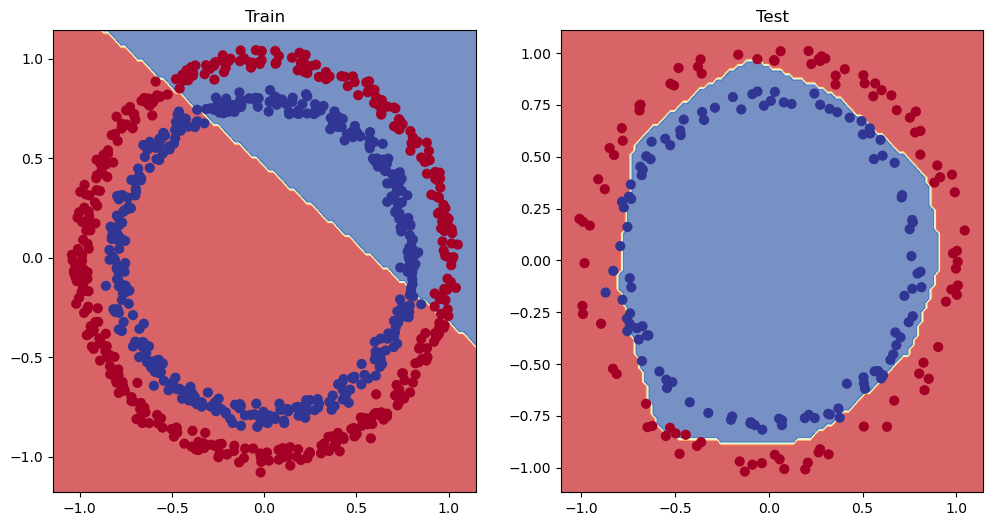

In [40]:
# now, let's plot the decision boundaries over train and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 with no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 with non-linearity

### 7. Replicating non-linear activation functions

In [41]:
# Toy tensor
A = torch.arange(-10, 10, 1, dtype = torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

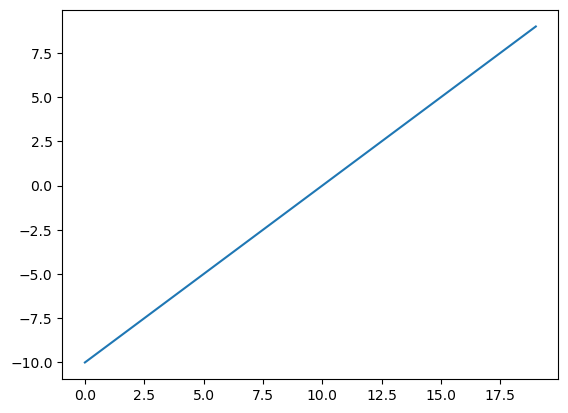

In [42]:
# Visualize the tensor
plt.plot(A)

In [43]:
# ReLU function creation by hand
def relu(x):
    return torch.maximum(torch.tensor(0), x) # tensor inputs

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

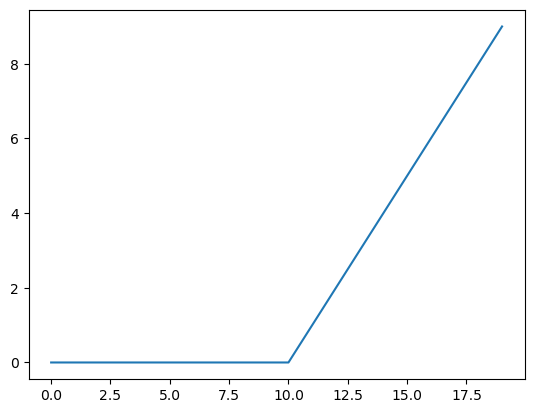

In [44]:
# Plot the RelU activated toy tensor
plt.plot(relu(A))

In [45]:
# Custom Sigmoid function creation
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

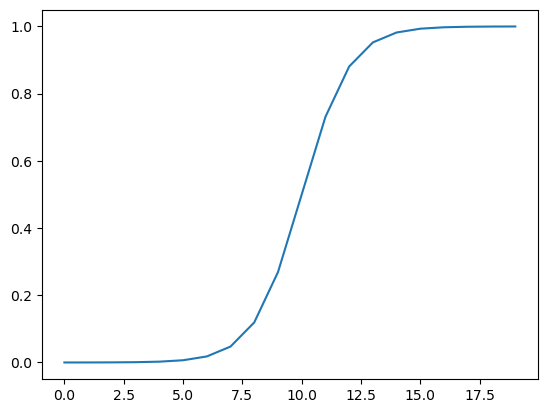

In [46]:
# Sigmoid function visualised
plt.plot(sigmoid(A))

### 8. Putting everything together by building a multi-class PyTorch model

#### 8.1 Creating multi-class classification data

In [47]:
import torch
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

tensor([[-4.0128,  4.3032],
        [-3.5961,  5.2537],
        [-8.2663, -7.5547],
        [-8.4175, -7.6973],
        [ 0.1422, -5.9335]]) tensor([1, 1, 3, 3, 2])


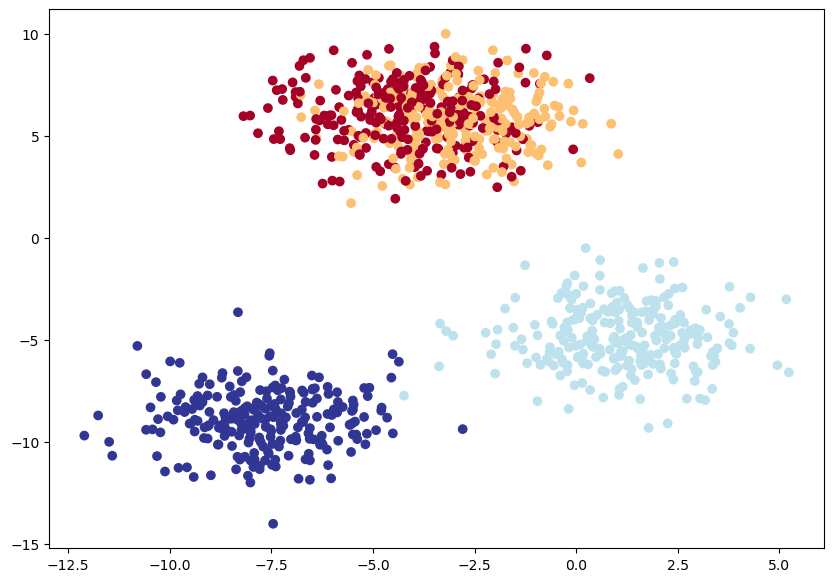

In [48]:
# Hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 69

# Create multi-class data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES, # X features
                            centers = NUM_CLASSES, # y labels
                            cluster_std = 1.5, # Similar to noise aound a specific centered-value
                            random_state = RANDOM_SEED)

# Convert the created data (currently in mp arrays) to tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# Data splitting
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# Data Visualization
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap = plt.cm.RdYlBu)

#### 8.2 Building a multi-class classification model in PyTorch

In [49]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [50]:
from torch import nn

# Building Model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        '''
        Initializes all reqd hyperparms for a multi-class model.
        input_features -> num of input features (in X) to the model
        output_features -> num of output features of the model (final layer neurons)
        hidden_units have their usual meaning.
        '''
        super().__init__()
        self.linear_layet_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # Is non-linearity required looking at the data plot ? Uncomment to find out.
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # Think the same as above
            nn.Linear(in_features=hidden_units, out_features=output_features) # Number of claases in y
        )

    def forward(self, x):
        return self.linear_layet_stack(x)

# Instantiate the model class and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layet_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

#### 8.3 Creating a loss function and optimizer for a multi-class PyTorch model

In [51]:
# Loss function and optimizer creation
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_4.parameters(), lr = 0.05) # Try playing around with the lr

#### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In [52]:
# Testing the ground - performing a single forward pass
model_4(X_blob_train.to(device))[:5] # Model is outputting logits rn

tensor([[ 0.1492,  0.1935, -0.4142,  0.0647],
        [ 0.4808,  1.0707, -0.6714, -0.9283],
        [ 0.3652,  0.0914, -0.4128,  0.1295],
        [-0.1497,  0.2324, -0.3238,  0.0363],
        [-0.0512,  0.2425, -0.3321,  0.0551]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [53]:
# How many elements in a single prediction sample ?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [54]:
# To go from logits -> prediciton probabilities -> prediciton labels, use Softmax activation function and torch.argmax()

# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Performing softmax activation on logits across dim=1 to get pred probs
y_pred_probs = torch.softmax(y_logits, dim=1)

print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.7540,  0.6412, -0.3270, -0.2119],
        [ 0.0758,  0.6494, -0.4963, -0.4908],
        [-0.2077,  0.3297, -0.3969, -0.1549],
        [-0.3588,  0.4954, -0.5241, -0.5021],
        [-0.2735,  0.5854, -0.4512, -0.4736]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.3827, 0.3418, 0.1298, 0.1457],
        [0.2560, 0.4543, 0.1445, 0.1453],
        [0.2177, 0.3726, 0.1802, 0.2295],
        [0.1975, 0.4640, 0.1674, 0.1711],
        [0.1993, 0.4706, 0.1669, 0.1632]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [55]:
# Since the softmax provides pred probs of each class, the probs should add up to 1
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [56]:
# The index of the highest value in the pred probs of each sample is the class (predicted) of that sample.
# To find the index, use torch.argmax()
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3827, 0.3418, 0.1298, 0.1457], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(0, device='cuda:0')


#### 8.5 Creating a training and testing loop for a multi-class PyTorch model

In [57]:
# Model fitting
torch.manual_seed(69)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    # Training
    model_4.train()
    y_logits = model_4(X_blob_train) # raw logits outputted
    y_pred = torch.softmax(y_logits, dim = 1).argmax(dim=1) # from logits -> pred probs -> pred labels
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy(y_true=y_blob_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim = 1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy(y_true = y_blob_test, y_pred = test_pred)

    # Print the stats
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f}, Train Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 1.67184, Train Accuracy: 17.38% | Test Loss: 1.46130, Test Accuracy: 23.50%
Epoch: 10 | Train Loss: 1.14361, Train Accuracy: 41.00% | Test Loss: 1.10333, Test Accuracy: 48.00%
Epoch: 20 | Train Loss: 0.82200, Train Accuracy: 69.25% | Test Loss: 0.78467, Test Accuracy: 73.50%
Epoch: 30 | Train Loss: 0.55192, Train Accuracy: 70.62% | Test Loss: 0.54074, Test Accuracy: 74.00%
Epoch: 40 | Train Loss: 0.45490, Train Accuracy: 71.50% | Test Loss: 0.45442, Test Accuracy: 73.50%
Epoch: 50 | Train Loss: 0.41699, Train Accuracy: 74.50% | Test Loss: 0.42035, Test Accuracy: 76.50%
Epoch: 60 | Train Loss: 0.39711, Train Accuracy: 79.88% | Test Loss: 0.40306, Test Accuracy: 78.50%
Epoch: 70 | Train Loss: 0.38454, Train Accuracy: 81.50% | Test Loss: 0.39288, Test Accuracy: 75.50%
Epoch: 80 | Train Loss: 0.37559, Train Accuracy: 80.62% | Test Loss: 0.38635, Test Accuracy: 77.00%
Epoch: 90 | Train Loss: 0.36878, Train Accuracy: 80.88% | Test Loss: 0.38194, Test Accuracy: 76.50%


#### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [58]:
# Testing the model for predictions and the output format (logits)
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-1.4653, -1.5257,  4.9669, -0.0499],
        [-1.5593, -1.5256,  0.7384,  3.5535],
        [ 2.0279,  1.6150, -2.8512, -2.3265],
        [ 2.5156,  1.7818, -3.9992, -2.7781],
        [-1.5688, -1.4216, -0.4404,  3.6383],
        [-1.2443, -1.6388, -2.9102,  3.0246],
        [ 3.2587,  3.0885, -3.4692, -4.4748],
        [-1.7476, -1.8315,  6.3130, -0.4871],
        [-1.3604, -1.3881,  5.0315, -0.6314],
        [ 3.1254,  3.2011, -3.0534, -4.4340]], device='cuda:0')

In [59]:
# View the pred probs and pred labels
y_pred_probs = torch.softmax(y_logits, dim = 1)
y_preds = torch.argmax(y_pred_probs, dim = 1)

y_preds[:10], y_blob_test[:10], accuracy(y_true=y_blob_test, y_pred = y_preds)

(tensor([2, 3, 0, 0, 3, 3, 0, 2, 2, 1], device='cuda:0'),
 tensor([2, 3, 0, 0, 3, 3, 0, 2, 2, 1], device='cuda:0'),
 75.5)

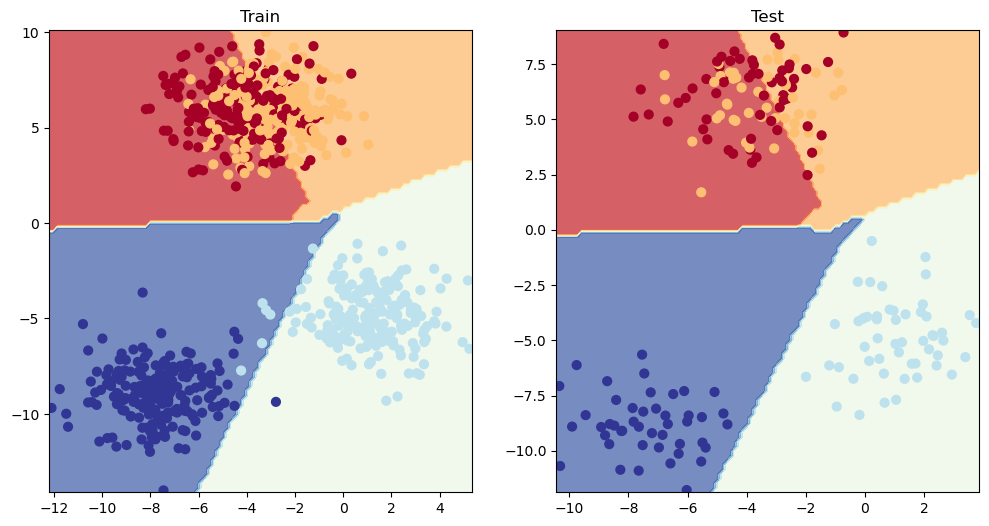

In [60]:
# Visualize the decision boundary over train and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### 9. More classification evaluation metrics

The most common ways of evaluating a classification model are accuracy, loss and visualizing predicitons.

In [61]:
# Trying the PyTorch-like version of Scikit-Learn for implementations of metrics (TorchMetrics)
try:
    from torchmetrics import Accuracy
except:
    ! pip install torchmetrics==0.9.3
    from torchmetrics import Accuracy

# Setup metric on the target device
torchmetrics_accuracy = Accuracy(task = "multiclass", num_classes = 4).to(device)

# Calculate the accuracy metric
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.7550, device='cuda:0')

## Exercises

In [62]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [63]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples = 1000, noise = 0.03, random_state = 42)
X[:5], y[:5]

(array([[-0.00933187,  0.39098105],
        [ 0.95457387, -0.47375583],
        [ 0.9185256 , -0.42519648],
        [ 0.41276802, -0.37638459],
        [-0.84532016,  0.52879908]]),
 array([1, 1, 1, 1, 0]))

In [64]:
import pandas as pd
moons = pd.DataFrame({"X1" : X[:, 0], "X2" : X[:, 1], "label" : y})
moons.head(10)

,X1,X2,label
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0
5,0.579542,-0.352979,1
6,0.294884,-0.209238,1
7,-0.014488,0.435896,1
8,1.626510,-0.281207,1
9,0.671598,0.786422,0


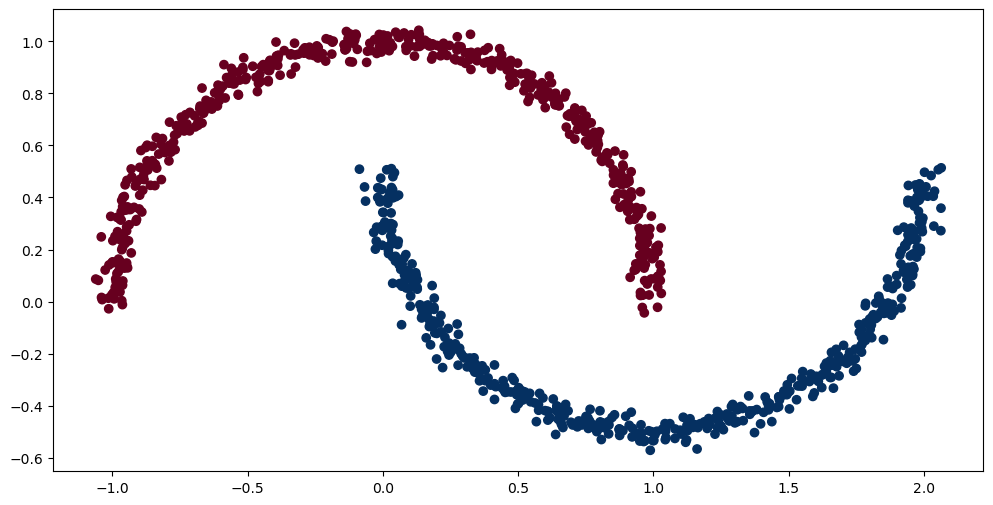

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [66]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[-0.0093,  0.3910],
         [ 0.9546, -0.4738],
         [ 0.9185, -0.4252],
         [ 0.4128, -0.3764],
         [-0.8453,  0.5288]]),
 tensor([1., 1., 1., 1., 0.]))

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [68]:
from torch import nn
class MoonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=13)
        self.layer_2 = nn.Linear(in_features=13, out_features=15)
        self.layer_3 = nn.Linear(in_features=15, out_features=15)
        self.layer_4 = nn.Linear(in_features=15, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

moon_model_ex = MoonModel().to(device)
moon_model_ex

MoonModel(
  (layer_1): Linear(in_features=2, out_features=13, bias=True)
  (layer_2): Linear(in_features=13, out_features=15, bias=True)
  (layer_3): Linear(in_features=15, out_features=15, bias=True)
  (layer_4): Linear(in_features=15, out_features=1, bias=True)
  (relu): ReLU()
)

In [69]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=moon_model_ex.parameters(), lr = 0.075)

In [70]:
y_logits = moon_model_ex(X_train.to(device)).squeeze()
y_pred_probs = torch.sigmoid(y_logits).squeeze()
y_preds = torch.round(y_pred_probs).squeeze()

print(y_logits)
print(y_pred_probs)
print(y_preds)

tensor([-0.0231, -0.0381, -0.0309, -0.0309, -0.0342, -0.0298, -0.0345, -0.0312,
        -0.0319, -0.0396, -0.0357, -0.0318, -0.0392, -0.0321, -0.0332, -0.0292,
        -0.0313, -0.0302, -0.0348, -0.0376, -0.0232, -0.0261, -0.0408, -0.0325,
        -0.0371, -0.0368, -0.0311, -0.0324, -0.0322, -0.0321, -0.0352, -0.0299,
        -0.0310, -0.0243, -0.0412, -0.0321, -0.0275, -0.0378, -0.0336, -0.0342,
        -0.0367, -0.0322, -0.0301, -0.0308, -0.0307, -0.0257, -0.0295, -0.0275,
        -0.0293, -0.0323, -0.0306, -0.0317, -0.0312, -0.0367, -0.0368, -0.0337,
        -0.0281, -0.0239, -0.0354, -0.0346, -0.0364, -0.0313, -0.0310, -0.0343,
        -0.0367, -0.0282, -0.0354, -0.0321, -0.0410, -0.0322, -0.0294, -0.0308,
        -0.0340, -0.0298, -0.0311, -0.0325, -0.0303, -0.0315, -0.0276, -0.0336,
        -0.0359, -0.0349, -0.0307, -0.0230, -0.0323, -0.0305, -0.0320, -0.0350,
        -0.0319, -0.0292, -0.0302, -0.0309, -0.0320, -0.0351, -0.0319, -0.0308,
        -0.0298, -0.0342, -0.0304, -0.03

In [71]:
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device)
acc_fn

Accuracy()

In [72]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Training
    moon_model_ex.train()
    y_logits = moon_model_ex(X_train).squeeze()
    y_pred_probs = torch.sigmoid(y_logits)
    y_pred = torch.round(y_pred_probs)
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_pred.int(), y_train.int())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    moon_model_ex.eval()
    with torch.inference_mode():
        test_logits = moon_model_ex(X_test).squeeze()
        test_pred_probs = torch.sigmoid(test_logits)
        test_pred = torch.round(test_pred_probs)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred.int(), y_test.int())

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.3f}, Train Acc: {acc:.3f} | Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f}")

Epoch: 0 | Train Loss: 0.693, Train Acc: 0.500 | Test Loss: 0.693, Test Acc: 0.500
Epoch: 10 | Train Loss: 0.690, Train Acc: 0.556 | Test Loss: 0.690, Test Acc: 0.610
Epoch: 20 | Train Loss: 0.687, Train Acc: 0.788 | Test Loss: 0.687, Test Acc: 0.760
Epoch: 30 | Train Loss: 0.684, Train Acc: 0.812 | Test Loss: 0.684, Test Acc: 0.760
Epoch: 40 | Train Loss: 0.679, Train Acc: 0.825 | Test Loss: 0.680, Test Acc: 0.830
Epoch: 50 | Train Loss: 0.674, Train Acc: 0.819 | Test Loss: 0.674, Test Acc: 0.810
Epoch: 60 | Train Loss: 0.665, Train Acc: 0.819 | Test Loss: 0.666, Test Acc: 0.810
Epoch: 70 | Train Loss: 0.652, Train Acc: 0.817 | Test Loss: 0.654, Test Acc: 0.810
Epoch: 80 | Train Loss: 0.634, Train Acc: 0.819 | Test Loss: 0.636, Test Acc: 0.810
Epoch: 90 | Train Loss: 0.608, Train Acc: 0.825 | Test Loss: 0.610, Test Acc: 0.810
Epoch: 100 | Train Loss: 0.573, Train Acc: 0.827 | Test Loss: 0.577, Test Acc: 0.815
Epoch: 110 | Train Loss: 0.532, Train Acc: 0.824 | Test Loss: 0.540, Test Ac

In [73]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 1.], device='cuda:0', grad_fn=<RoundBackward0>)


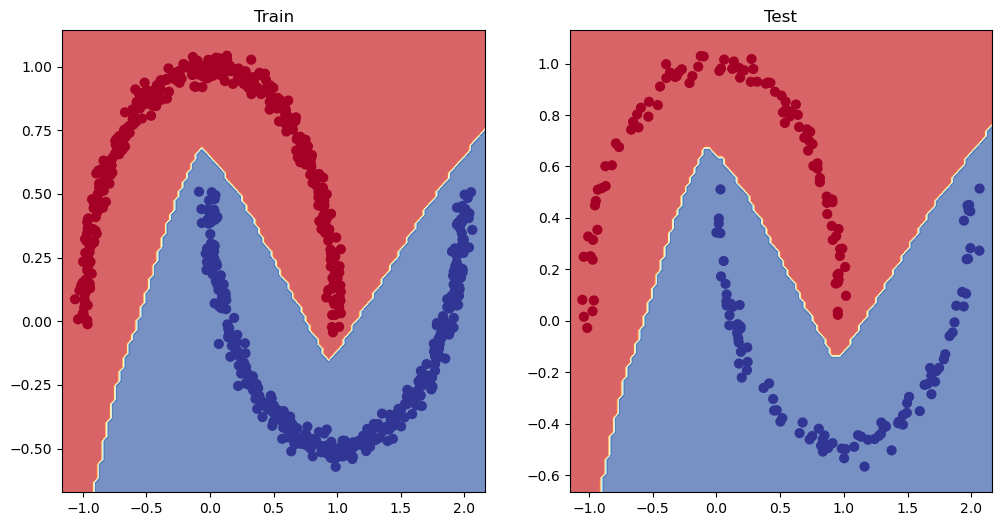

In [74]:
y_preds = torch.round(torch.sigmoid(moon_model_ex(X_test).squeeze()))
print(y_preds)
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(moon_model_ex, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(moon_model_ex, X_test, y_test)

In [75]:
def tanh(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

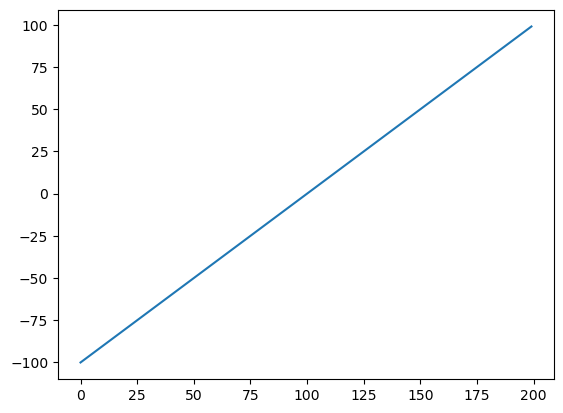

In [76]:
temp_tensor = torch.arange(-100, 100, 1)
plt.plot(temp_tensor)

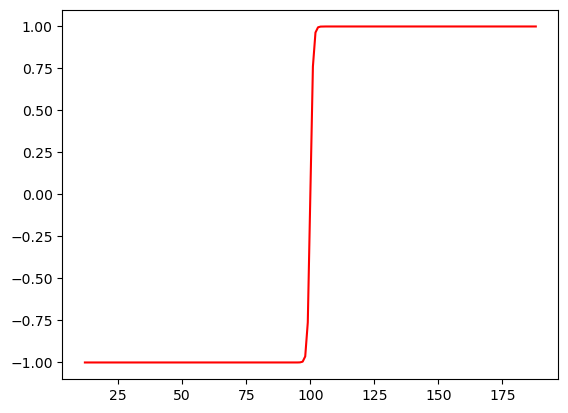

In [77]:
plt.plot(tanh(temp_tensor), "r-")

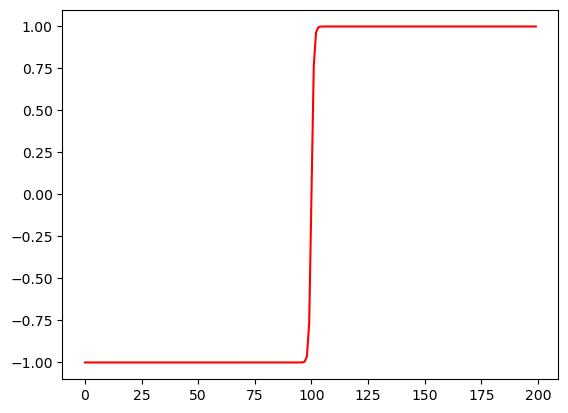

In [78]:
plt.plot(torch.tanh(temp_tensor), "r-")

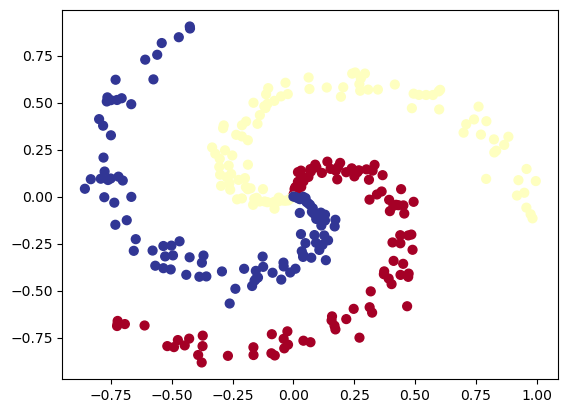

In [79]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [80]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
class SpiralDataModel(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_features, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=13)
        self.layer_3 = nn.Linear(in_features=13, out_features=13)
        self.layer_4 = nn.Linear(in_features=13, out_features=output_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return(self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))))))

spiral = SpiralDataModel(input_features=2, output_features=3).to(device)
spiral

SpiralDataModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=13, bias=True)
  (layer_3): Linear(in_features=13, out_features=13, bias=True)
  (layer_4): Linear(in_features=13, out_features=3, bias=True)
  (relu): ReLU()
)

In [82]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = spiral.parameters(), lr = 0.1)
acc_func = Accuracy(task="multiclass", num_classes=3).to(device)

In [83]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Training
    spiral.train()
    y_logits = spiral(X_train)
    y_pred_probs = torch.softmax(y_logits, dim = 1)
    y_pred = torch.argmax(y_pred_probs, dim = 1)
    loss = loss_fn(y_logits, y_train)
    acc = acc_func(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    spiral.eval()
    with torch.inference_mode():
        test_logits = spiral(X_test)
        test_pred_probs = torch.softmax(test_logits, dim = 1)
        test_pred = torch.argmax(test_pred_probs, dim = 1)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_func(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.3f}, Train Acc: {acc:.3f} | Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f}")

Epoch: 0 | Train Loss: 1.121, Train Acc: 0.325 | Test Loss: 1.099, Test Acc: 0.267
Epoch: 100 | Train Loss: 0.025, Train Acc: 0.988 | Test Loss: 0.000, Test Acc: 1.000
Epoch: 200 | Train Loss: 0.018, Train Acc: 0.992 | Test Loss: 0.000, Test Acc: 1.000
Epoch: 300 | Train Loss: 0.016, Train Acc: 0.992 | Test Loss: 0.000, Test Acc: 1.000
Epoch: 400 | Train Loss: 0.015, Train Acc: 0.992 | Test Loss: 0.000, Test Acc: 1.000
Epoch: 500 | Train Loss: 0.015, Train Acc: 0.992 | Test Loss: 0.000, Test Acc: 1.000
Epoch: 600 | Train Loss: 0.014, Train Acc: 0.992 | Test Loss: 0.000, Test Acc: 1.000
Epoch: 700 | Train Loss: 0.014, Train Acc: 0.992 | Test Loss: 0.000, Test Acc: 1.000
Epoch: 800 | Train Loss: 0.014, Train Acc: 0.992 | Test Loss: 0.000, Test Acc: 1.000
Epoch: 900 | Train Loss: 0.014, Train Acc: 0.992 | Test Loss: 0.000, Test Acc: 1.000


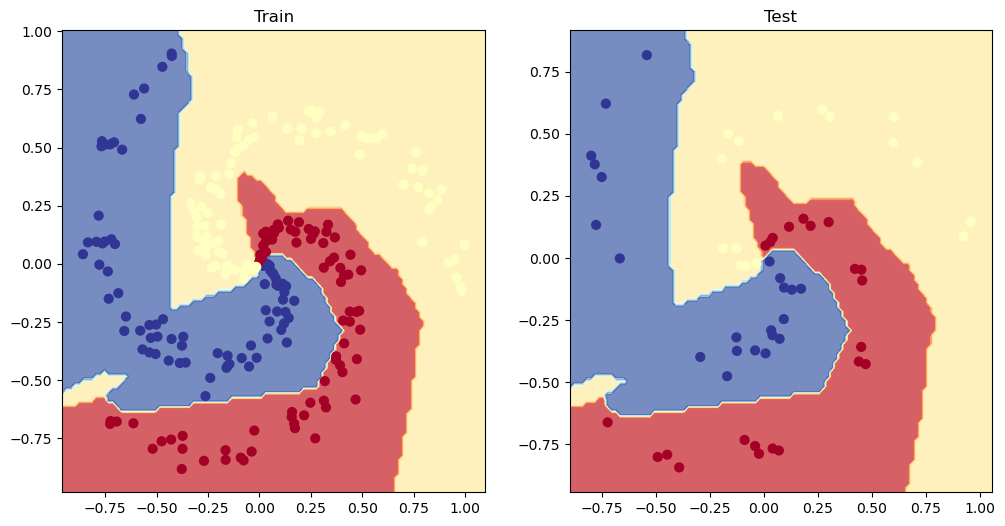

In [84]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(spiral, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(spiral, X_test, y_test)